In [151]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 66

# 各パス指定

In [152]:
dataset = 'model/keypoint_classifier/pose.csv'
model_save_path = 'model/keypoint_classifier/pose_classifier.hdf5'

# 分類数設定

In [153]:
NUM_CLASSES = 6

# 学習データ読み込み

In [154]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (33 * 2) + 1)))

In [155]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [157]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((33 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [158]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_12 (Dropout)        (None, 66)                0         
                                                                 
 dense_18 (Dense)            (None, 20)                1340      
                                                                 
 dropout_13 (Dropout)        (None, 20)                0         
                                                                 
 dense_19 (Dense)            (None, 10)                210       
                                                                 
 dense_20 (Dense)            (None, 6)                 66        
                                                                 
Total params: 1,616
Trainable params: 1,616
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
______________________________

In [159]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [160]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [161]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

1/1 [==============================] - 0s 36ms/step - loss: 0.5489 - accuracy: 0.8254 - val_loss: 0.2868 - val_accuracy: 0.8810
Epoch 167/1000
1/1 [==============================] - ETA: 0s - loss: 0.4502 - accuracy: 0.8095
Epoch 167: saving model to model/keypoint_classifier\posepoint_classifier.hdf5
1/1 [==============================] - 0s 44ms/step - loss: 0.4502 - accuracy: 0.8095 - val_loss: 0.2832 - val_accuracy: 0.8810
Epoch 168/1000
1/1 [==============================] - ETA: 0s - loss: 0.4429 - accuracy: 0.8492
Epoch 168: saving model to model/keypoint_classifier\posepoint_classifier.hdf5
1/1 [==============================] - 0s 42ms/step - loss: 0.4429 - accuracy: 0.8492 - val_loss: 0.2796 - val_accuracy: 0.9286
Epoch 169/1000
1/1 [==============================] - ETA: 0s - loss: 0.4994 - accuracy: 0.8254
Epoch 169: saving model to model/keypoint_classifier\posepoint_classifier.hdf5
1/1 [==============================] - 0s 37ms/step - loss: 0.4994 - accuracy: 0.8254 - val

Epoch 1/1000
1/1 [==============================] - ETA: 0s - loss: 1.8356 - accuracy: 0.0873
Epoch 1: saving model to model/keypoint_classifier\posepoint_classifier.hdf5
1/1 [==============================] - 1s 642ms/step - loss: 1.8356 - accuracy: 0.0873 - val_loss: 1.7704 - val_accuracy: 0.0476
Epoch 2/1000
1/1 [==============================] - ETA: 0s - loss: 1.8247 - accuracy: 0.1429
Epoch 2: saving model to model/keypoint_classifier\posepoint_classifier.hdf5
1/1 [==============================] - 0s 44ms/step - loss: 1.8247 - accuracy: 0.1429 - val_loss: 1.7568 - val_accuracy: 0.0238
Epoch 3/1000
1/1 [==============================] - ETA: 0s - loss: 1.8126 - accuracy: 0.1508
Epoch 3: saving model to model/keypoint_classifier\posepoint_classifier.hdf5
1/1 [==============================] - 0s 40ms/step - loss: 1.8126 - accuracy: 0.1508 - val_loss: 1.7439 - val_accuracy: 0.1429
Epoch 4/1000
1/1 [==============================] - ETA: 0s - loss: 1.7812 - accuracy: 0.1825
Epoch 4:

Epoch 1/1000
1/1 [==============================] - ETA: 0s - loss: 1.9015 - accuracy: 0.0873
Epoch 1: saving model to model/keypoint_classifier\posepoint_classifier.hdf5
1/1 [==============================] - 1s 533ms/step - loss: 1.9015 - accuracy: 0.0873 - val_loss: 1.8623 - val_accuracy: 0.0000e+00
Epoch 2/1000
1/1 [==============================] - ETA: 0s - loss: 1.8323 - accuracy: 0.0952
Epoch 2: saving model to model/keypoint_classifier\posepoint_classifier.hdf5
1/1 [==============================] - 0s 38ms/step - loss: 1.8323 - accuracy: 0.0952 - val_loss: 1.8406 - val_accuracy: 0.0000e+00
Epoch 3/1000
1/1 [==============================] - ETA: 0s - loss: 1.8334 - accuracy: 0.1111
Epoch 3: saving model to model/keypoint_classifier\posepoint_classifier.hdf5
1/1 [==============================] - 0s 41ms/step - loss: 1.8334 - accuracy: 0.1111 - val_loss: 1.8194 - val_accuracy: 0.0000e+00
Epoch 4/1000
1/1 [==============================] - ETA: 0s - loss: 1.8469 - accuracy: 0.1

In [162]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

1/1 [==============================] - 0s 17ms/step - loss: 0.0031 - accuracy: 1.0000


In [163]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [164]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 40ms/step
[2.5290987e-08 2.7855501e-08 2.9160501e-05 9.9996865e-01 4.0599247e-07
 1.7822812e-06]
3
1/1 [==============================] - 0s 41ms/step
[1.5917123e-05 2.6679460e-05 5.0064348e-02 9.4778156e-01 1.3948801e-05
 2.0974565e-03]
3


1/1 [==============================] - 0s 43ms/step
[9.7149741e-13 2.3290458e-10 1.1541503e-03 9.9883825e-01 7.1936097e-06
 4.3977195e-07]
3


# 混同行列

2/2 [==============================] - 0s 2ms/step


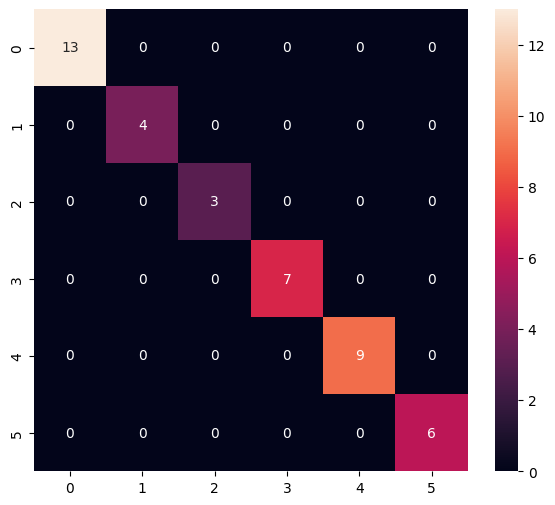

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00         6

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42

2/2 [==============================] - 0s 1ms/step


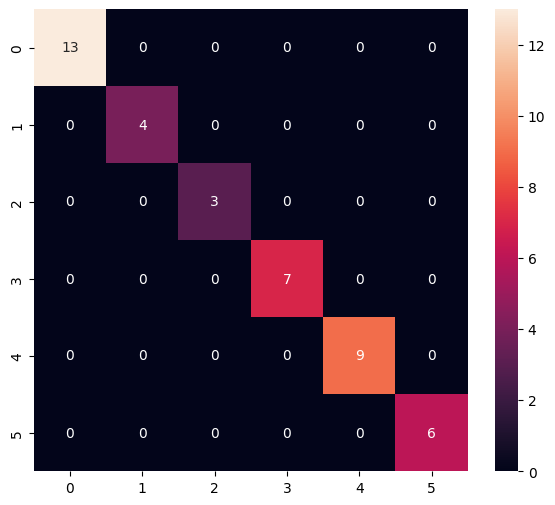

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00         6

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42

2/2 [==============================] - 0s 3ms/step


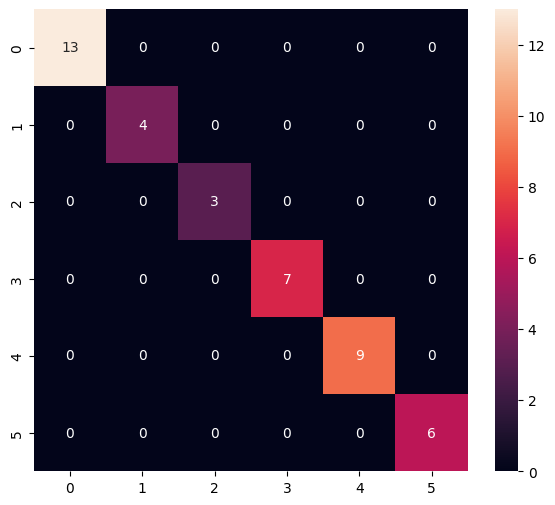

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00         6

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42



In [165]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [166]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [167]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/pose_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\SSAFY\AppData\Local\Temp\tmp0o2_fmw_\assets


INFO:tensorflow:Assets written to: C:\Users\SSAFY\AppData\Local\Temp\tmp0o2_fmw_\assets


4760

INFO:tensorflow:Assets written to: C:\Users\SSAFY\AppData\Local\Temp\tmpdwaoq414\assets


INFO:tensorflow:Assets written to: C:\Users\SSAFY\AppData\Local\Temp\tmpdwaoq414\assets


4760

INFO:tensorflow:Assets written to: C:\Users\SSAFY\AppData\Local\Temp\tmp3lavxztp\assets


INFO:tensorflow:Assets written to: C:\Users\SSAFY\AppData\Local\Temp\tmp3lavxztp\assets


4760

# 推論テスト

In [168]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [169]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [170]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [171]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 1 ms
CPU times: total: 0 ns
Wall time: 0 ns
CPU times: total: 0 ns
Wall time: 0 ns


In [172]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.4834865e-08 2.7754169e-08 2.8686172e-05 9.9996912e-01 4.0125235e-07
 1.7746057e-06]
3
[1.5685122e-05 2.6434025e-05 4.9912557e-02 9.4793987e-01 1.3723081e-05
 2.0916928e-03]
3
[9.8744266e-13 2.3855892e-10 1.1648883e-03 9.9882740e-01 7.1941008e-06
 4.4415907e-07]
3
